# Difference in Differences II

ECON526

Paul Schrimpf (University of British Columbia)

# Difference in Differences

$$
\def\Er{{\mathrm{E}}}
\def\En{{\mathbb{E}_n}}
\def\cov{{\mathrm{Cov}}}
\def\var{{\mathrm{Var}}}
\def\R{{\mathbb{R}}}
\newcommand\norm[1]{\left\lVert#1\right\rVert}
\def\rank{{\mathrm{rank}}}
\newcommand{\inpr}{ \overset{p^*_{\scriptscriptstyle n}}{\longrightarrow}}
\def\inprob{{\,{\buildrel p \over \rightarrow}\,}}
\def\indist{\,{\buildrel d \over \rightarrow}\,}
\DeclareMathOperator*{\plim}{plim}
$$

## Setup

-   ~~Two~~ Many periods, binary treatment in ~~second~~ some periods
-   Potential outcomes $\{y_{it}(0),y_{it}(1)\}_{t=1}^T$ for $i=1,...,N$
-   Treatment $D_{it} \in \{0,1\}$,
    -   $D_{i0} = 0$ $\forall i$
    -   $D_{i1} = 1$ for some, $0$ for others
-   Observe $y_{it} = y_{it}(0)(1-D_{it}) + D_{it} y_{it}(1)$

## Identification

-   Same logic as before, $$
    \begin{align*}
    ATT_{t,t-s} & = \Er[y_{it}(1) - \color{red}{y_{it}(0)} | D_{it} = 1, D_{it-s}=0] \\
    & = \Er[y_{it}(1) - y_{it-s}(0) | D_{it} = 1, D_{it-s}=0] - \\
    & \;\; -  \Er[\color{red}{y_{it}(0)} - y_{t-s}(0) | D_{it}=1, D_{it-s}=0]
    \end{align*}
    $$

    -   assume
        $\Er[\color{red}{y_{it}(0)} - y_{it-s}(0) | D_{it}=1,  D_{it-s}=0] = \Er[y_{it}(0) - y_{it-s}(0) | D_{it}=0, D_{it-s}=0]$

$$
\begin{align*}
ATT_{t,t-s}& = \Er[y_{it} - y_{it-s} | D_{it}=1, D_{it-s}=0] - \Er[y_{it} - y_{it-s} | D_{it}=0, D_{it-s}=0]
\end{align*}
$$ - Similarly, can identify various other interpretable average
treatment effects conditional on being treated at some times and not
others

## Estimation

-   Plugin

-   Fixed effects? $$
    y_{it} = \beta D_{it} + \alpha_i + \delta_t + \epsilon_{it}
    $$ When will $\hat{\beta}^{FE}$ consistently estimate some
    interpretable conditional average of treatment effects?

## Fixed Effects

-   As with [matching](matching.qmd), $$
    \begin{align*}
    \hat{\beta} = & \sum_{i=1,t=1}^{n,T} y_{it} \overbrace{\frac{\tilde{D}_{it}}{ \sum_{i,t} \tilde{D}_{it}^2 }}^{\hat{\omega}_{it}} = \sum_{i=1,t=1}^{n,T} y_{it}(0) \hat{\omega}_{it} + \sum_{i=1,t=1}^{n,T} D_{it} (y_{it}(1) - y_{it}(0)) \hat{\omega}_{it}
    \end{align*}
    $$ where $$
    \begin{align*}
    \tilde{D}_{it} & = D_{it} - \frac{1}{n} \sum_{j=1}^n (D_{jt} - \frac{1}{T} \sum_{s=1}^T D_{js}) - \frac{1}{T} \sum_{s=1}^T D_{is} \\
    & = D_{it} - \frac{1}{n} \sum_{j=1}^n D_{jt} - \frac{1}{T} \sum_{s=1}^T D_{is} + \frac{1}{nT} \sum_{j,s} D_{js}
    \end{align*}
    $$

In [1]:
import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
style.use("fivethirtyeight")

## Weights

In [2]:
def assigntreat(n, T, portiontreated):
    treated = np.zeros((n, T), dtype=bool)
    for t in range(1, T):
        treated[:, t] = treated[:, t - 1]
        if portiontreated[t] > 0:
            treated[:, t] = np.logical_or(treated[:, t-1], np.random.rand(n) < portiontreated[t])
    return treated

def weights(D):
    D̈ = D - np.mean(D, axis=0) - np.mean(D, axis=1)[:, np.newaxis] + np.mean(D)
    ω = D̈ / np.sum(D̈**2)
    return ω

n = 100
T = 9
pt = np.zeros(T)
pt[T//2 + 1] = 0.5
D = assigntreat(n, T,pt)
y = np.random.randn(n, T)
weighted_sum = np.sum(y * weights(D))
print(weighted_sum)

0.08147854863434313

## Using a package

In [3]:
# check that it matches fixed effect estimate from a package
import pyfixest as pf

df = pd.DataFrame({
    'id': np.repeat(np.arange(1, n + 1), T),
    't': np.tile(np.arange(1, T + 1), n),
    'y': y.flatten(),
    'D': D.flatten()
})
result=pf.feols('y ~ D | id + t', df, vcov={"CRV1": "id"})
result.summary()

###

Estimation:  OLS
Dep. var.: y, Fixed effects: id+t
Inference:  CRV1
Observations:  900

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| D             |      0.081 |        0.133 |     0.610 |      0.543 | -0.183 |   0.346 |
---
RMSE: 0.953 R2: 0.109 R2 Within: 0.0 

## Weights with Single Treatment Time

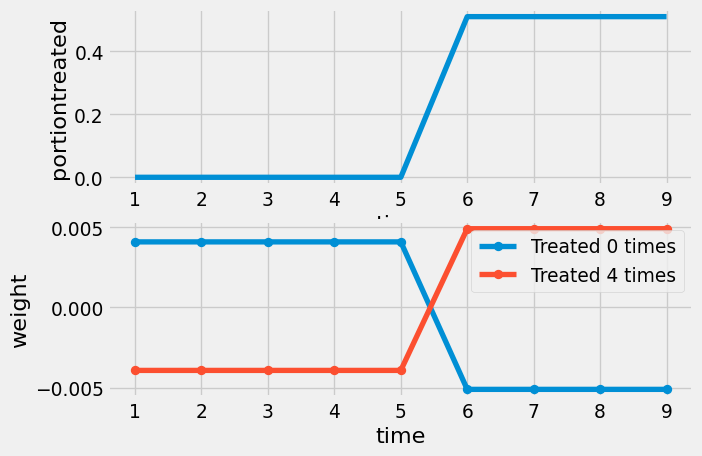

In [4]:
def plotD(D,ax):
    n, T = D.shape
    ax.set(xlabel='time',ylabel='portiontreated')
    ax.plot(range(1,T+1),D.mean(axis=0))
    ax

def plotweights(D, ax):
    n, T = D.shape
    ω = weights(D)
    groups = np.unique(D, axis=0)
    ax.set(xlabel='time', ylabel='weight')

    for g in groups:
        i = np.where(np.all(D == g, axis=1))[0][0]
        wt = ω[i, :]
        ax.plot(range(1, T+1), wt, marker='o', label=f'Treated {np.sum(g)} times')

    ax.legend()
    ax

def plotwd(D):
    fig, ax = plt.subplots(2,1)
    ax[0]=plotD(D,ax[0])
    ax[1]=plotweights(D,ax[1])
    plt.show()

plotwd(D)

## Weights with Early and Late Treated

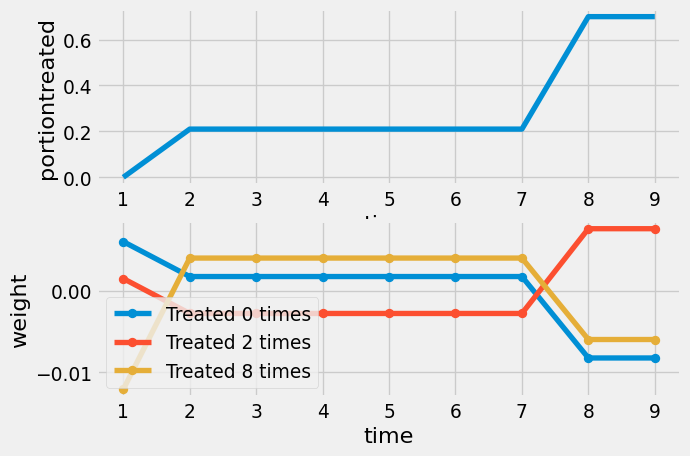

In [5]:
pt = np.zeros(T)
pt[1] = 0.3
pt[T-2] = 0.6
D = assigntreat(n,T,pt)
plotwd(D)

## Sign Reversal

In [6]:
dvals = np.unique(D,axis=0)
dvals.sort()
ATT = np.ones(T)
ATT[0] = 0.0
ATT[T-2:T] = 6.0
np.random.seed(6798)

def simulate(n,T,pt,ATT,sigma=1.0):
    D = assigntreat(n,T,pt)
    y = np.random.randn(n,T)*sigma + ATT[np.cumsum(D, axis=1)]
    df = pd.DataFrame({
        'id': np.repeat(np.arange(1, n + 1), T),
        't': np.tile(np.arange(1, T + 1), n),
        'y': y.flatten(),
        'D': D.flatten()
    })
    return(df)

df = simulate(n,T,pt,ATT)
result = pf.feols('y ~ D | id + t',  df, vcov={"CRV1": "id"})
result.summary()

###

Estimation:  OLS
Dep. var.: y, Fixed effects: id+t
Inference:  CRV1
Observations:  900

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| D             |     -0.526 |        0.249 |    -2.107 |      0.038 | -1.020 |  -0.031 |
---
RMSE: 1.287 R2: 0.51 R2 Within: 0.009 

## When to worry

-   If multiple treatment times and treatment heterogeneity
-   Even if weights do not have wrong sign, the fixed effects estimate
    is hard to interpret
-   Same logic applies more generally – not just to time
    -   E.g. if have group effects, some treated units in multiple
        groups, and $E[y(1) - y(0) | group]$ varies

## What to Do?

-   Follow identification $$
    \begin{align*}
    ATT_{t,t-s}& = \Er[y_{it} - y_{it-s} | D_{it}=1, D_{it-s}=0] - \Er[y_{it} - y_{it-s} | D_{it}=0, D_{it-s}=0]
    \end{align*}
    $$ and estimate $$
    \begin{align*}
    \widehat{ATT}_{t,t-s} = & \frac{\sum_i y_{it} D_{it}(1-D_{it-s})}{\sum_i D_{it}(1-D_{it-s})} \\
    & - \frac{\sum_i y_{it} (1-D_{it})(1-D_{it-s})}{\sum_i (1-D_{it})(1-D_{it-s})}
    \end{align*}
    $$ and perhaps some average, e.g. (there are other reasonable
    weighted averages) $$
    \sum_{t=1}^T \frac{\sum_i D_{it}}{\sum_{i,s} D_{i,s}} \frac{1}{t-1} \sum_{s=1}^{t-1} \widehat{ATT}_{t,t-s}
    $$
    -   Code? Inference? Optimal? (could create it, but there’s an
        easier way)

## What to Do?

-   Option 1: Use an appropriate package
    -   [differences](https://github.com/bernardodionisi/differences)
    -   [pyfixest](https://pypi.org/project/pyfixest/) (Gardner’s
        2-stage estimator or Dube et al (2023) local projections)
    -   doubleml (see chapter 16 of Chernozhukov et al. (2024))
    -   see https://asjadnaqvi.github.io/DiD/ for more options (but none
        are python)

## What to Do?

-   Option 2: estimate a correctly specified fixed effects regression
    (my preferred approach)

-   Problem is possible correlation of $(y_{it}(1) - y_{it}(0))D_{it}$
    with $\tilde{D}_{it}$

-   $\tilde{D}_{it}$ is function of $t$ and $(D_{i1}, ..., D_{iT})$

-   Estimating separate coefficient for each combination of $t$ and
    $(D_{i1}, ..., D_{iT})$ will eliminate correlation / flexibly model
    treatment effect heterogeneity

## What to Do?

-   Cohorts = unique sequences of $(D_{i1}, ..., D_{iT})$
    -   In current simulated example, three cohorts
        1.  $(0, 0, 0, 0, 0, 0, 0, 0, 0)$
        2.  $(0, 0, 0, 0, 0, 0, 0, 1, 1)$
        3.  $(0, 1, 1, 1, 1, 1, 1, 1, 1)$

## Regression with Cohort-time Interactions

-   Estimate: $$
    y_{it} = \sum_{c=1}^C D_{it} 1\{C_i=c\} \beta_{ct} + \alpha_i + \delta_t + \epsilon_{it}
    $$

-   $\hat{\beta}_{ct}$ consistently estimates
    $\Er[y_{it}(1) - y_{it}(0) | C_{i}=c, D_{it}=1]$ assuming parallel
    trends holds for all periods $$
    \Er[y_{it}(0) - y_{it-s}(0) | C_i=c] = \Er[y_{it}(0) - y_{it-s}(0) | C_i=c']
    $$ for all $t, s, c, c'$

## Regression with Cohort Interactions

In [7]:
def definecohort(df):
    # convert dummies into categorical
    n = len(df.id.unique())
    T = len(df.t.unique())
    df = df.set_index(['id','t'])
    dmat=np.array(df.sort_index().D)
    dmat=np.array(df.D).reshape(n,T)
    cohort=dmat.dot(1 << np.arange(dmat.shape[-1] - 1, -1, -1))
    cdf = pd.DataFrame({"id":np.array(df.index.levels[0]), "cohort":pd.Categorical(cohort)})
    cdf =cdf.set_index('id')
    df = df.reset_index().set_index('id')
    df=pd.merge(df, cdf, left_index=True, right_index=True)
    df=df.reset_index()
    return(df)

dfc = definecohort(df)

def defineinteractions(df):
    df['dct'] = 'untreated'
    df['dct'] = df.apply(lambda x: f"t{x['t']},c{x['cohort']}" if x['D'] else f"untreated", axis=1)
    return(df)

dfc = defineinteractions(dfc)

modc = pf.feols("y ~  C(dct, Treatment('untreated')) | id + t", dfc, vcov={"CRV1": "id"})
pf.etable([modc], type="md")

index                                           est1
-----------------------------------------  ---------
depvar                                             y
----------------------------------------------------
C(dct, Treatment('untreated'))[T.t2,c255]     0.524
                                             (0.277)
C(dct, Treatment('untreated'))[T.t3,c255]    0.761*
                                             (0.320)
C(dct, Treatment('untreated'))[T.t4,c255]   0.820**
                                             (0.304)
C(dct, Treatment('untreated'))[T.t5,c255]   0.880**
                                             (0.329)
C(dct, Treatment('untreated'))[T.t6,c255]     0.458
                                             (0.285)
C(dct, Treatment('untreated'))[T.t7,c255]    0.624*
                                             (0.307)
C(dct, Treatment('untreated'))[T.t8,c255]  5.242***
                                             (0.408)
C(dct, Treatment('untreated'))[T.t8,c3]    1.121***
 

## Regression with Cohort Interactions

/tmp/ipykernel_1065352/325906362.py:12: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


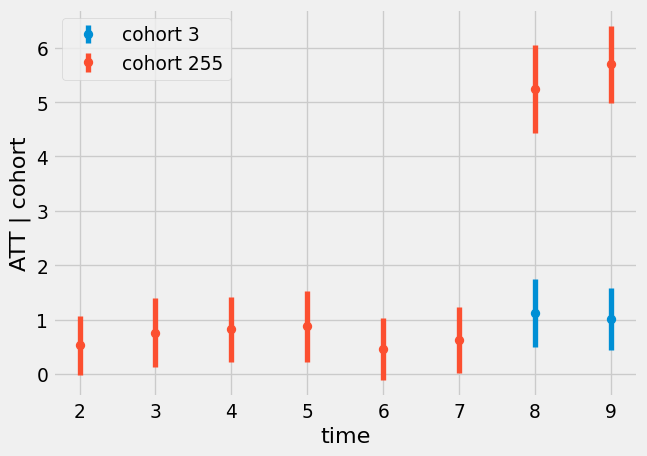

In [8]:
import re
def plotcohortatt(modc):
    coef = modc.coef()
    ci = modc.confint()
    tcregex = re.compile(r".+t(\d+),c(\d+)]")
    catt = pd.DataFrame(index=coef.index, columns=['t','c','att','yerr'])
    for i in range(len(coef)):
        m = tcregex.match(coef.index[i])
        t,c = m.groups()
        t=int(t)
        c=int(c)
        catt.loc[coef.index[i]] = [t,c,coef.iloc[i],np.abs(ci.iloc[i][0]-coef.iloc[i])]

    catt.sort_values(['c','t'],inplace=True)
    fig, ax = plt.subplots()
    ax.set(xlabel='time', ylabel='ATT | cohort')
    for g in catt.groupby('c') :
        c = g[0]
        g = g[1]
        ax.errorbar(g['t'], g['att'], yerr=g['yerr'], fmt='o', label=f'cohort {c}')

    ax.legend()
    return(fig)

fig=plotcohortatt(modc)

## Regression with Cohort-Time Interactions

-   If just want to assume parallel trends for treated and never
    treated, i.e. $$
    \Er[y_{it}(0) - y_{it-s}(0) | C_i=c] = \Er[y_{it}(0) - y_{it-s}(0) | C_i=c']
    $$ when $c$ treated at $t$, untreated at $t-s$ and $c'$ never
    treated

-   Estimate $$
    y_{it} = \sum_{c=1}^C 1\{C_i=c\} \delta_{c,t} + \alpha_i + \epsilon_{it}
    $$

## Regression with Cohort-Time Interactions

$$
y_{it} = \sum_{c=1}^C 1\{C_i=c\} \delta_{c,t} + \alpha_i + \epsilon_{it}
$$

-   $\hat{\delta}_{c,t} + \frac{\sum \alpha_i 1\{C_i=c\}}{\sum 1\{C_i =
    c\}}$ consistently estimates $\Er[y_{it} | C_{i} = c]$
-   $\hat{\delta}_{c,t} -\hat{\delta}_{c,t-s}$ consistently estimates
    $\Er[y_{it} - y_{i,t-s}| C_{i} = c]$
-   If $c$ treated at $t$, not at $t-s$, and $c'$ not treated at either
    and assume parallel trends, $$
    \hat{\delta}_{c,t} - \hat{\delta}_{c,t-s} - (\hat{\delta}_{c',t} -\hat{\delta}_{c',t-s}) \inprob \Er[y_{it}(1)-y{it}(0)| C_i =c]
    $$

## Regression with Cohort-Time Interactions

In [9]:
modct = pf.feols("y ~ C(cohort)*C(t) | id + t",dfc, vcov={"CRV1":"id"})
pf.etable(modct, type='md')

/home/paul/526/mine/site/.venv/lib/python3.12/site-packages/pyfixest/estimation/feols_.py:2283: UserWarning:


            The following variables are collinear: ['C(cohort)[T.3]', 'C(cohort)[T.255]', 'C(t)[T.2]', 'C(t)[T.3]', 'C(t)[T.4]', 'C(t)[T.5]', 'C(t)[T.6]', 'C(t)[T.7]', 'C(t)[T.8]', 'C(t)[T.9]'].
            The variables are dropped from the model.
            


index                            est1
--------------------------  ---------
depvar                              y
-------------------------------------
C(cohort)[T.3]:C(t)[T.2]       0.288
                              (0.355)
C(cohort)[T.255]:C(t)[T.2]    0.696*
                              (0.338)
C(cohort)[T.3]:C(t)[T.3]       0.248
                              (0.404)
C(cohort)[T.255]:C(t)[T.3]    0.909*
                              (0.404)
C(cohort)[T.3]:C(t)[T.4]       0.386
                              (0.343)
C(cohort)[T.255]:C(t)[T.4]   1.051**
                              (0.350)
C(cohort)[T.3]:C(t)[T.5]      -0.119
                              (0.375)
C(cohort)[T.255]:C(t)[T.5]    0.809*
                              (0.405)
C(cohort)[T.3]:C(t)[T.6]       0.480
                              (0.291)
C(cohort)[T.255]:C(t)[T.6]    0.745*
                              (0.338)
C(cohort)[T.3]:C(t)[T.7]       0.309
                              (0.360)
C(cohort)[T.255]:C(t)[T

# Pre-Trends

## Pre-trends

-   Parallel trends assumption

$$
\Er[\color{red}{y_{it}(0)} - y_{it-s}(0) | D_{it}=1,  D_{it-s}=0] = \Er[y_{it}(0) - y_{it-s}(0) | D_{it}=0, D_{it-s}=0]
$$

-   More plausible if there are parallel pre-trends

$$
\begin{align*}
& \Er[y_{it-r}(0) - y_{it-s}(0) | D_{it}=1, D_{it-r}=0,  D_{it-s}=0] = \\
& = \Er[y_{it-r}(0) - y_{it-s}(0) | D_{it}=0, D_{it-r}=0, D_{it-s}=0]
\end{align*}
$$

-   Always at least plot pre-trends

## Pre-trends

/tmp/ipykernel_1065352/1668444176.py:36: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


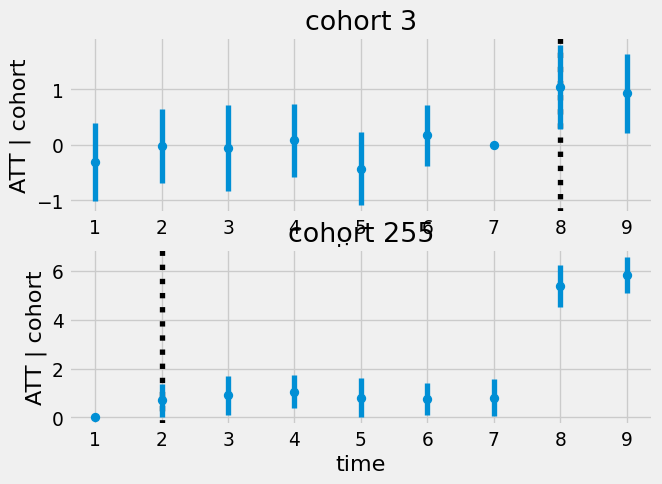

In [10]:
def eventstudyplot(modct) :
    evdf = pd.DataFrame(index=modct.coef().index, columns=['c', 't','delta','did','se','vindex'])
    pattern=r".+T\.(\d+).+\[T\.(\d+)\]"
    for i in range(len(modct.coef())):
        m = re.match(pattern, modct.coef().index[i])
        c,t = m.groups()
        t = int(t)
        c = int(c)
        evdf.loc[modct.coef().index[i]] = [c,t,modct.coef().iloc[i],0, 0, i]

    evdf.sort_values(['c','t'],inplace=True)
    T = evdf['t'].max()
    V = modct._vcov
    evdf.reset_index(inplace=True)
    for t in range(T) :
        if not (t+1) in evdf.t.unique() :
            ndf = pd.DataFrame(columns=evdf.columns)
            ndf.c=evdf.c.unique()
            ndf.t=t+1
            ndf.delta=0
            ndf.vindex=V.shape[0]
            evdf=pd.concat([evdf,ndf])
    V = np.vstack([V,np.zeros(V.shape[1])])
    V = np.hstack([V,np.zeros((V.shape[0],1))])

    def did(g) :
        c = g.c.unique()[0]
        timestreated = bin(c).count('1')
        t0 = T - timestreated
        g=g.set_index('t')
        g['did'] = g['delta'] - g['delta'][t0]
        vi = g['vindex'].to_numpy().astype(int)
        g['se'] = np.sqrt(V[vi,vi] - 2*V[g['vindex'][t0],vi] + V[g['vindex'][t0],g['vindex'][t0]])
        return(g)

    evdf=evdf.groupby('c').apply(did).drop(columns='c').reset_index()

    fig, ax = plt.subplots(len(evdf.c.unique()),1)
    for (i,g) in enumerate(evdf.groupby('c')) :
        c = g[0]
        g = g[1]
        timestreated = bin(c).count('1')
        t0 = T - timestreated + 1
        ax[i].axvline(t0, color='black', ls=":")
        ax[i].errorbar(g['t'], g['did'], yerr=1.96*g['se'], fmt='o', label=f'cohort {c}')
        ax[i].set_title(f'cohort {c}')
        ax[i].set(xlabel='time', ylabel='ATT | cohort')

    return(fig)

fig=eventstudyplot(modct)

## Testing for Pre-trends

-   Is it a good idea to test

$$
\begin{align*}
H_0 : & \Er[y_{it-r} - y_{it-s} | D_{it}=1, D_{it-r}=0,  D_{it-s}=0] = \\
& = \Er[y_{it-r} - y_{it-s} | D_{it}=0, D_{it-r}=0, D_{it-s}=0]?
\end{align*}
$$ - Even if not testing formally, we do it informally by plotting

## Testing for Pre-trends

-   Distribution of $\hat{ATT}$ conditional on fail to reject parallel
    pre-trends is not normal

-   Roth (2022) : test can have low power, and in plausible violations,
    $\widehat{ATT}_{3,2}$ conditional on failing to reject is biased

## Bounds from Pre-trends

-   Let $\Delta$ be violation of parallel trends $$
    \Delta = \Er[\color{red}{y_{it}(0)} - y_{it-1}(0) | D_{it}=1,  D_{it-1}=0] - \Er[y_{it}(0) - y_{it-1}(0) | D_{it}=0, D_{it-1}=0]
    $$

-   Assume $\Delta$ is bounded by deviation from parallel of pre-trends
    $$
    |\Delta| \leq M \max_{r} \left\vert \tau^{1t}_{t-r,t-r-1} - \tau^{0t}_{t-r,t-r-1} \right\vert
    $$ for some chosen $M$

-   See Rambachan and Roth (2023)

# Covariates

## Doubly Robust Difference in Differences

-   Linear covariates could lead to same problem as with matching

-   Doubly robust estimator Sant’Anna and Zhao (2020)

    -   [doubleml](https://docs.doubleml.org/stable/examples/py_double_ml_did.html)
        package implements it
    -   see example notebook from chapter 16 of Chernozhukov et al.
        (2024)

## Sources and Further Reading

-   Facure (2022, chap. 1)
-   Huntington-Klein (2021, chap. 16)
-   Book: C. de Chaisemartin and D’Haultfœuille (2023)
-   Recent reviews: Roth et al. (2023), Clément de Chaisemartin and
    D’Haultfœuille (2022), Arkhangelsky and Imbens (2023)
-   Early work pointing to problems with fixed effects:
    -   Laporte and Windmeijer (2005), Wooldridge (2005)
-   Explosion of papers written just before 2020, published just after:
    -   Borusyak and Jaravel (2018)
    -   Clément de Chaisemartin and D’Haultfœuille (2020)
    -   Callaway and Sant’Anna (2021)
    -   Goodman-Bacon (2021)
    -   Sun and Abraham (2021)

## References

Arkhangelsky, Dmitry, and Guido Imbens. 2023. “Causal Models for
Longitudinal and Panel Data: A Survey.”

Borusyak, Kirill, and Xavier Jaravel. 2018. “Revisiting Event Study
Designs.”
<https://scholar.harvard.edu/files/borusyak/files/borusyak_jaravel_event_studies.pdf>.

Callaway, Brantly, and Pedro H. C. Sant’Anna. 2021.
“Difference-in-Differences with Multiple Time Periods.” *Journal of
Econometrics* 225 (2): 200–230.
https://doi.org/<https://doi.org/10.1016/j.jeconom.2020.12.001>.

Chaisemartin, C de, and X D’Haultfœuille. 2023. *Credible Answers to
Hard Questions: Differences-in-Differences for Natural Experiments*.
<https://dx.doi.org/10.2139/ssrn.4487202>.

Chaisemartin, Clément de, and Xavier D’Haultfœuille. 2020. “Two-Way
Fixed Effects Estimators with Heterogeneous Treatment Effects.”
*American Economic Review* 110 (9): 2964–96.
<https://doi.org/10.1257/aer.20181169>.

———. 2022. “<span class="nocase">Two-way fixed effects and
differences-in-differences with heterogeneous treatment effects: a
survey</span>.” *The Econometrics Journal* 26 (3): C1–30.
<https://doi.org/10.1093/ectj/utac017>.

Chernozhukov, V., C. Hansen, N. Kallus, M. Spindler, and V. Syrgkanis.
2024. *Applied Causal Inference Powered by ML and AI*.
<https://causalml-book.org/>.

Facure, Matheus. 2022. *Causal Inference for the Brave and True*.
<https://matheusfacure.github.io/python-causality-handbook/landing-page.html>.

Goodman-Bacon, Andrew. 2021. “Difference-in-Differences with Variation
in Treatment Timing.” *Journal of Econometrics* 225 (2): 254–77.
https://doi.org/<https://doi.org/10.1016/j.jeconom.2021.03.014>.

Huntington-Klein, Nick. 2021. *The Effect: An Introduction to Research
Design and Causality*. CRC Press. <https://theeffectbook.net/>.

Laporte, Audrey, and Frank Windmeijer. 2005. “Estimation of Panel Data
Models with Binary Indicators When Treatment Effects Are Not Constant
over Time.” *Economics Letters* 88 (3): 389–96.
https://doi.org/<https://doi.org/10.1016/j.econlet.2005.04.002>.

Rambachan, Ashesh, and Jonathan Roth. 2023. “<span class="nocase">A More
Credible Approach to Parallel Trends</span>.” *The Review of Economic
Studies* 90 (5): 2555–91. <https://doi.org/10.1093/restud/rdad018>.

Roth, Jonathan. 2022. “Pretest with Caution: Event-Study Estimates After
Testing for Parallel Trends.” *American Economic Review: Insights* 4
(3): 305–22. <https://doi.org/10.1257/aeri.20210236>.

Roth, Jonathan, Pedro H. C. Sant’Anna, Alyssa Bilinski, and John Poe.
2023. “What’s Trending in Difference-in-Differences? A Synthesis of the
Recent Econometrics Literature.” *Journal of Econometrics* 235 (2):
2218–44.
https://doi.org/<https://doi.org/10.1016/j.jeconom.2023.03.008>.

Sant’Anna, Pedro H. C., and Jun Zhao. 2020. “Doubly Robust
Difference-in-Differences Estimators.” *Journal of Econometrics* 219
(1): 101–22.
https://doi.org/<https://doi.org/10.1016/j.jeconom.2020.06.003>.

Sun, Liyang, and Sarah Abraham. 2021. “Estimating Dynamic Treatment
Effects in Event Studies with Heterogeneous Treatment Effects.” *Journal
of Econometrics* 225 (2): 175–99.
https://doi.org/<https://doi.org/10.1016/j.jeconom.2020.09.006>.

Wooldridge, Jeffrey M. 2005. “<span class="nocase">Fixed-Effects and
Related Estimators for Correlated Random-Coefficient and
Treatment-Effect Panel Data Models</span>.” *The Review of Economics and
Statistics* 87 (2): 385–90. <https://doi.org/10.1162/0034653053970320>.